# Libs

In [1]:
import os
import sys
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cv2
from PIL import Image, ImageFile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import shutil

# It is important to make sure that mediapipe is installed and running, as it is essential \
# to preprocess the OOD dataset: "annotated driver drowsiness"
try:
    import mediapipe as mp
except:
    !pip install --upgrade google-api-core protobuf mediapipe
    import mediapipe as mp

2025-06-28 20:33:31.628071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751142811.650594     203 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751142811.657187     203 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Initialization

## In Domain Dataset

In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

train_images_path = "/kaggle/input/driver-inattention-detection-dataset/train"
annotation_file_path = "/kaggle/input/driver-inattention-detection-dataset/train/_annotations.txt"

# These labels from the original datasets 
class_names = {
    0: 'DangerousDriving', 1: 'Distracted', 2: 'Drinking',
    3: 'SafeDriving', 4: 'SleepyDriving', 5: 'Yawn'
}

batch_size = 16

# In Domain Dataset
base_dir = "/kaggle/input/driver-inattention-detection-dataset"

# train
train_images = os.path.join(base_dir, 'train')
train_annotations = os.path.join(train_images, "_annotations.txt")

# val
val_images = os.path.join(base_dir, 'valid')
val_annotations = os.path.join(val_images, "_annotations.txt")

# test
test_images = os.path.join(base_dir, 'test')
test_annotations = os.path.join(test_images, "_annotations.txt")

## Out Of Domain Dataset

In [3]:
# Rearrange the folder of the "annotated-driver-drowsiness" dataset to use the same preprocessing pipeline. 
# Here we used mediapipe to downsize the images into the face only.

BASE_DATA_DIR = '/kaggle/input/annotated-driver-drowsiness'
OUTPUT_DIR_PATH = '/kaggle/working/combined_ood_dataset'


def combine_datasets_on_kaggle():
    print("Starting dataset processing with MediaPipe face detection...")

    # --- 1. Initialize MediaPipe Face Detection ---
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(
        model_selection=1,
        min_detection_confidence=0.5
    )

    # Define paths
    source_sub_dirs = ['valid', 'test']
    output_images_path = os.path.join(OUTPUT_DIR_PATH, 'images')
    output_annotation_path = os.path.join(OUTPUT_DIR_PATH, 'annotations.txt')

    # --- 2. Setup the output directory ---
    if os.path.exists(OUTPUT_DIR_PATH):
        shutil.rmtree(OUTPUT_DIR_PATH)
    os.makedirs(output_images_path)

    try:
        # --- 3. Open the master annotation file to write the corrected data ---
        with open(output_annotation_path, 'w') as master_annotation_file:
            print(f"Opened '{output_annotation_path}' for writing corrected annotations.")
            
            for dir_name in source_sub_dirs:
                print(f"\nProcessing directory: '{dir_name}'")
                
                source_image_dir = os.path.join(BASE_DATA_DIR, dir_name, 'images')
                source_label_dir = os.path.join(BASE_DATA_DIR, dir_name, 'labels')

                if not os.path.isdir(source_image_dir) or not os.path.isdir(source_label_dir):
                    print(f"Warning: A required directory was not found in '{dir_name}'. Skipping.")
                    continue

                image_files = [f for f in os.listdir(source_image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                print(f"Found {len(image_files)} images.")

                for image_filename in image_files:
                    source_image_path = os.path.join(source_image_dir, image_filename)
                    
                    # --- a. Read the image with OpenCV ---
                    image = cv2.imread(source_image_path)
                    if image is None:
                        print(f"Warning: Could not read image {image_filename}. Skipping.")
                        continue

                    # --- b. Run MediaPipe Face Detection ---
                    # First, check if the loaded image is grayscale (2 dimensions) or color (3 dimensions)
                    if len(image.shape) == 2 or image.shape[2] == 1:
                        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                    else:
                        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    results = face_detection.process(image_rgb)

                    # --- c. If a face is detected, generate new coordinates ---
                    if results.detections:
                        detection = results.detections[0]
                        bbox_relative = detection.location_data.relative_bounding_box
                        
                        img_height, img_width, _ = image.shape
                        
                        xmin = int(bbox_relative.xmin * img_width)
                        ymin = int(bbox_relative.ymin * img_height)
                        xmax = int((bbox_relative.xmin + bbox_relative.width) * img_width)
                        ymax = int((bbox_relative.ymin + bbox_relative.height) * img_height)

                        # --- d. Get the original class ID ---
                        base_filename = os.path.splitext(image_filename)[0]
                        label_filename = f"{base_filename}.txt"
                        source_label_path = os.path.join(source_label_dir, label_filename)
                        
                        if os.path.exists(source_label_path):
                            with open(source_label_path, 'r') as label_file:
                                line = label_file.read().strip()
                                class_id = line.split()[0]
                                
                                # --- e. Write the corrected line to the file ---
                                reformatted_annotation = f"{xmin},{ymin},{xmax},{ymax},{class_id}"
                                final_line = f"{image_filename} {reformatted_annotation}\n"
                                master_annotation_file.write(final_line)
                                
                                # And copy the image, since we are using its data
                                shutil.copy2(source_image_path, output_images_path)
                        else:
                            print(f"Warning: Label file not found for {image_filename}, even though face was detected. Skipping.")
                    else:
                        pass

        # --- 4. Clean up ---
        face_detection.close()
        print("\n-----------------------------------------")
        print("Script finished successfully!")
        print("The new annotations.txt file contains correct, full-face pixel coordinates.")
        print(f"Verified images and annotations are in: '{OUTPUT_DIR_PATH}'")
        print("-----------------------------------------")

    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        
combine_datasets_on_kaggle()

Starting dataset processing with MediaPipe face detection...
Opened '/kaggle/working/combined_ood_dataset/annotations.txt' for writing corrected annotations.

Processing directory: 'valid'
Found 783 images.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1751142815.154074     262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



Processing directory: 'test'
Found 782 images.

-----------------------------------------
Script finished successfully!
The new annotations.txt file contains correct, full-face pixel coordinates.
Verified images and annotations are in: '/kaggle/working/combined_ood_dataset'
-----------------------------------------


In [4]:
# Initialization
ood_test_images = '/kaggle/working/combined_ood_dataset/images'
ood_test_annotations = '/kaggle/working/combined_ood_dataset/annotations.txt'

ood_test_classnames = {
    0: 'drowsy', 1: 'not_drowsy'
}

# Parse annotations & Load cropped faces

In [5]:
def parse_annotation_line(line):
    """
    Parses a single line from the annotation file.
    Expected format: image_filename x_min,y_min,x_max,y_max,class_label
    """
    parts = line.strip().split(' ')
    if len(parts) < 2:
        print(f"Warning: Skipping malformed line: {line}")
        return None, None, None
        
    image_filename = parts[0]
    coords_and_label_str = parts[1]
    
    try:
        coords_parts = coords_and_label_str.split(',')
        if len(coords_parts) != 5:
            print(f"Warning: Malformed coordinates/label for {image_filename}: {coords_and_label_str}")
            return image_filename, None, None
            
        x_min = int(coords_parts[0])
        y_min = int(coords_parts[1])
        x_max = int(coords_parts[2])
        y_max = int(coords_parts[3])
        class_label = int(coords_parts[4])
        
        return image_filename, (x_min, y_min, x_max, y_max), class_label
    except ValueError as e:
        print(f"Warning: Error parsing coordinates/label for {image_filename}: {coords_and_label_str} - {e}")
        return image_filename, None, None
    
def load_and_crop_images(annotation_file_path, images_directory):
    """
    Loads image paths and metadata based on an annotation file.
    Returns a list of (image_path, bbox, label) tuples.
    """
    processed_data = []
    
    if not os.path.exists(annotation_file_path):
        print(f"Error: Annotation file not found at {annotation_file_path}")
        return processed_data
        
    if not os.path.isdir(images_directory):
        print(f"Error: Images directory not found at {images_directory}")
        return processed_data

    with open(annotation_file_path, 'r') as f:
        for line in f:
            image_filename, bbox, label = parse_annotation_line(line)
            
            if image_filename is None or bbox is None or label is None:
                continue

            image_path = os.path.join(images_directory, image_filename)
            
            if not os.path.exists(image_path):
                print(f"Warning: Image file not found: {image_path}")
                continue
                
            processed_data.append((image_path, bbox, label))
            
    return processed_data

# Dataset & Preprocessing

In [6]:
class CustomDatasetTF:
    def __init__(self, root_dir, annotation_file, class_names, batch_size=16):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.class_names = list(class_names.keys())
        self.num_classes = len(self.class_names)

        # Load image paths and metadata
        self.cropped_data = load_and_crop_images(annotation_file, self.root_dir)
        if not self.cropped_data:
            raise RuntimeError("No valid cropped faces loaded!")

    def _load_and_preprocess_image(self, image_path, bbox, label):
        # Read and decode the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)

        # Convert bbox to tensor
        x_min = bbox[0]
        y_min = bbox[1]
        x_max = bbox[2]
        y_max = bbox[3]
        
        # Get image dimensions
        img_shape = tf.shape(image)
        img_h = img_shape[0]
        img_w = img_shape[1]
        
        # Ensure coordinates are within image bounds
        x_min = tf.maximum(0, x_min)
        y_min = tf.maximum(0, y_min)
        x_max = tf.minimum(img_w, x_max)
        y_max = tf.minimum(img_h, y_max)
        
        # Calculate crop dimensions
        crop_height = y_max - y_min
        crop_width = x_max - x_min
        
        # Crop the image
        image = tf.image.crop_to_bounding_box(
            image, y_min, x_min, crop_height, crop_width
        )

        # Convert RGB to grayscale
        if image.shape[-1] == 3:
            img_array = tf.image.rgb_to_grayscale(image)
            img_array = tf.concat([img_array, img_array, img_array], axis=-1)

        
        # Resize the image to a fixed size
        target_size = (224, 224)
        image = tf.image.resize(img_array, target_size)
        
        # Convert to float and normalize
        image = tf.cast(image, tf.float32) / 255.0
        
        return image, label

    def create_dataset(self, shuffle=True):
        if not self.cropped_data:
            print(f"Warning: No samples in CustomDatasetTF for {self.root_dir} to create tf.data.Dataset from.")
            return None
            
        # Create dataset from paths and metadata
        image_paths = [s[0] for s in self.cropped_data]
        bboxes = [s[1] for s in self.cropped_data]
        labels = [s[2] for s in self.cropped_data]
    
        # Create the dataset
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, bboxes, labels))
    
        # Map the preprocessing function
        dataset = dataset.map(
            self._load_and_preprocess_image,
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # One-hot encode the labels
        def to_one_hot(image, label):
            label = tf.cast(label, tf.int32)
            label_one_hot = tf.one_hot(label, depth=self.num_classes, dtype=tf.float32)
            return image, label_one_hot
        
        dataset = dataset.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    
        if shuffle:

            # Shuffle the dataset
            buffer_size = min(len(self.cropped_data), 10000) 
            if buffer_size > 0: 
                dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    
        # Batch and prefetch
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
        return dataset

In [7]:
def load_dataset(images, annotation, class_names, batch_size=16):
    dataset = CustomDatasetTF(
        root_dir=images,
        annotation_file=annotation,
        class_names=class_names,
        batch_size=batch_size
    )
    
    # Create the dataset
    tf_dataset = dataset.create_dataset(shuffle=False)
    
    # Initialize empty lists for images and labels
    all_images = []
    all_labels = []
    
    # Process each batch
    print(f"Loading dataset from {images}...")
    for image_batch, label_batch in tf_dataset:
        # Convert to numpy and append
        for i in range(len(image_batch)):
            all_images.append(image_batch[i].numpy())
            all_labels.append(label_batch[i].numpy())
    
    # Stack into proper numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)
    
    print(f"Loaded {len(X)} images with shape {X.shape}")
    return X, y

# Train
X_train, y_train = load_dataset(
    images=train_images,
    annotation=train_annotations,
    class_names=class_names,
    batch_size=16
)

# Validation
X_val, y_val = load_dataset(
    images=val_images,
    annotation=val_annotations,
    class_names=class_names,
    batch_size=16
)

# Test
X_test, y_test = load_dataset(
    images=test_images,
    annotation=test_annotations,
    class_names=class_names,
    batch_size=16
)

# ood_test
X_ood_test, y_ood_test = load_dataset(
    images=ood_test_images,
    annotation=ood_test_annotations,
    class_names=ood_test_classnames,
    batch_size=16
)

I0000 00:00:1751142854.652534     203 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751142854.653223     203 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Loading dataset from /kaggle/input/driver-inattention-detection-dataset/train...
Loaded 11948 images with shape (11948, 224, 224, 3)
Loading dataset from /kaggle/input/driver-inattention-detection-dataset/valid...
Loaded 1922 images with shape (1922, 224, 224, 3)
Loading dataset from /kaggle/input/driver-inattention-detection-dataset/test...
Loaded 985 images with shape (985, 224, 224, 3)
Loading dataset from /kaggle/working/combined_ood_dataset/images...
Loaded 431 images with shape (431, 224, 224, 3)


# Statistics & Visualization

Training Data:

Class Distribution:
  Class 0 (DangerousDriving): 3732 samples (31.24%)
  Class 1 (Distracted): 1676 samples (14.03%)
  Class 2 (Drinking): 347 samples (2.90%)
  Class 3 (SafeDriving): 4969 samples (41.59%)
  Class 4 (SleepyDriving): 785 samples (6.57%)
  Class 5 (Yawn): 439 samples (3.67%)


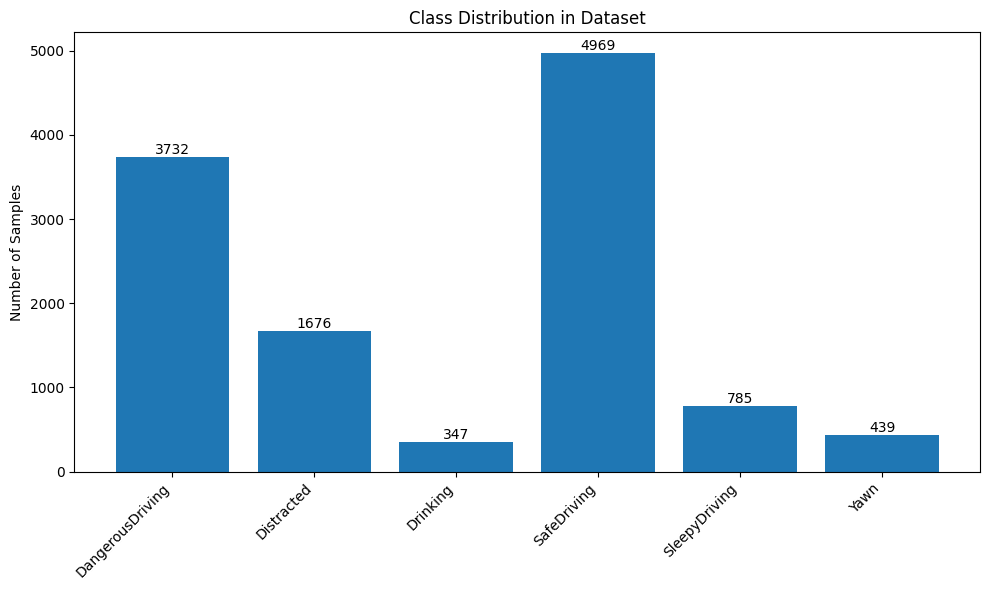


Validation Data:

Class Distribution:
  Class 0 (DangerousDriving): 609 samples (31.69%)
  Class 1 (Distracted): 252 samples (13.11%)
  Class 2 (Drinking): 56 samples (2.91%)
  Class 3 (SafeDriving): 799 samples (41.57%)
  Class 4 (SleepyDriving): 125 samples (6.50%)
  Class 5 (Yawn): 81 samples (4.21%)


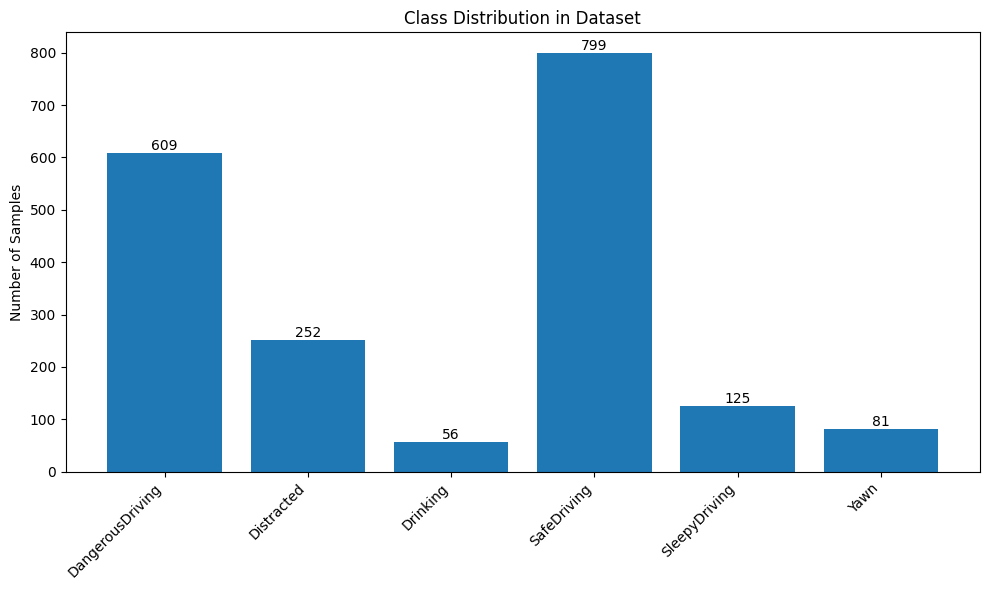


Test Data:

Class Distribution:
  Class 0 (DangerousDriving): 301 samples (30.56%)
  Class 1 (Distracted): 152 samples (15.43%)
  Class 2 (Drinking): 25 samples (2.54%)
  Class 3 (SafeDriving): 412 samples (41.83%)
  Class 4 (SleepyDriving): 69 samples (7.01%)
  Class 5 (Yawn): 26 samples (2.64%)


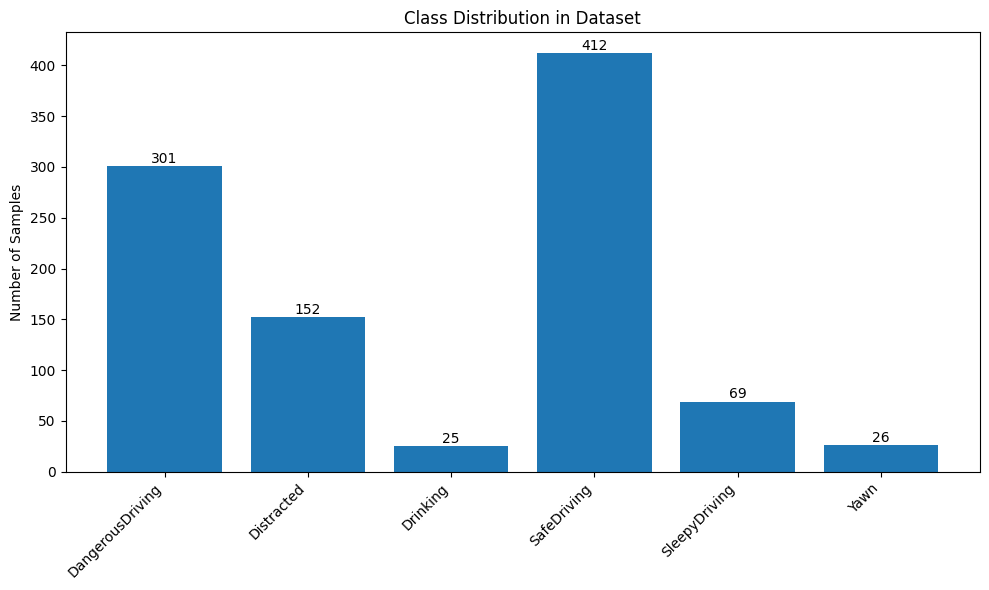


OOD Test Data:

Class Distribution:
  Class 0 (drowsy): 197 samples (45.71%)
  Class 1 (not_drowsy): 234 samples (54.29%)


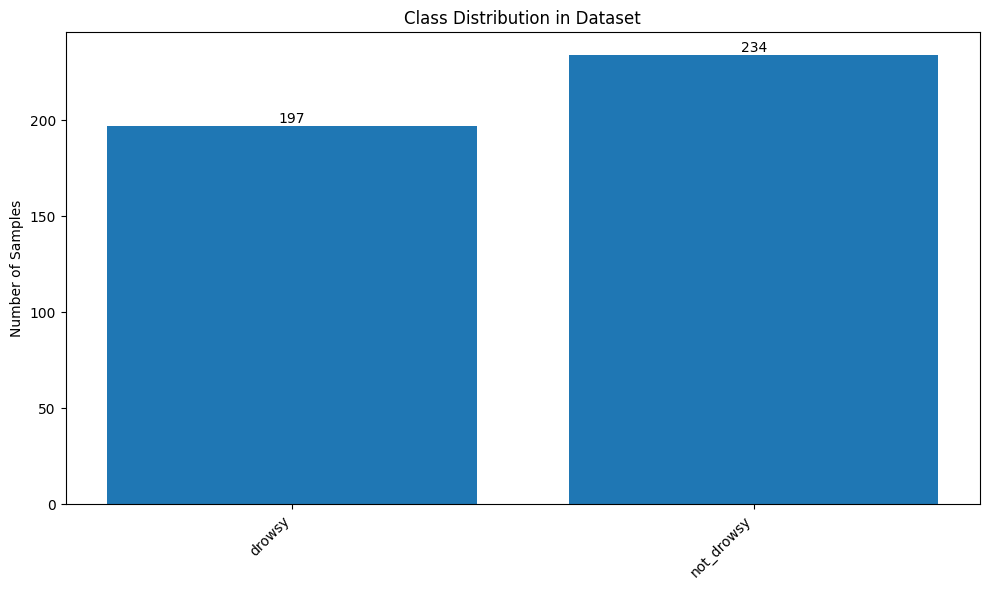

In [8]:
def check_class_distribution(labels, class_names):
    """Check and visualize class distribution in a dataset"""
    class_indices = np.argmax(labels, axis=1)
    classes, counts = np.unique(class_indices, return_counts=True)
    
    print("\nClass Distribution:")
    for i, (cls, count) in enumerate(zip(classes, counts)):
        class_name = class_names[cls] if cls in class_names else f"Unknown Class {cls}"
        print(f"  Class {cls} ({class_name}): {count} samples ({count/len(labels)*100:.2f}%)")
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        [class_names[cls] if cls in class_names else f"Class {cls}" for cls in classes], 
        counts
    )
    
    # Add count labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}', ha='center', va='bottom'
        )
    
    plt.title('Class Distribution in Dataset')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Check distribution for each dataset
print("Training Data:")
check_class_distribution(y_train, class_names)

print("\nValidation Data:")
check_class_distribution(y_val, class_names)

print("\nTest Data:")
check_class_distribution(y_test, class_names)

print("\nOOD Test Data:")
check_class_distribution(y_ood_test, ood_test_classnames)

In [9]:
def check_data_ranges(images, name="Dataset"):
    """Verify the range of values in your image data"""
    print(f"\n{name} Statistics:")
    print(f"  Shape: {images.shape}")
    print(f"  Data Type: {images.dtype}")
    print(f"  Min Value: {images.min()}")
    print(f"  Max Value: {images.max()}")
    print(f"  Mean: {images.mean():.4f}")
    print(f"  Std Dev: {images.std():.4f}")
    
    # Check for NaN or infinity values
    n_nan = np.isnan(images).sum()
    n_inf = np.isinf(images).sum()
    if n_nan > 0 or n_inf > 0:
        print(f"  WARNING: Found {n_nan} NaN values and {n_inf} infinity values")

# Check ranges for each dataset
check_data_ranges(X_train, "Training Data")
check_data_ranges(X_val, "Validation Data")
check_data_ranges(X_test, "Test Data")
check_data_ranges(X_ood_test, "OOD Test Data")


Training Data Statistics:
  Shape: (11948, 224, 224, 3)
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean: 0.3474
  Std Dev: 0.2549

Validation Data Statistics:
  Shape: (1922, 224, 224, 3)
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean: 0.3477
  Std Dev: 0.2562

Test Data Statistics:
  Shape: (985, 224, 224, 3)
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean: 0.3492
  Std Dev: 0.2561

OOD Test Data Statistics:
  Shape: (431, 224, 224, 3)
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean: 0.4820
  Std Dev: 0.2638


Training Data Samples:


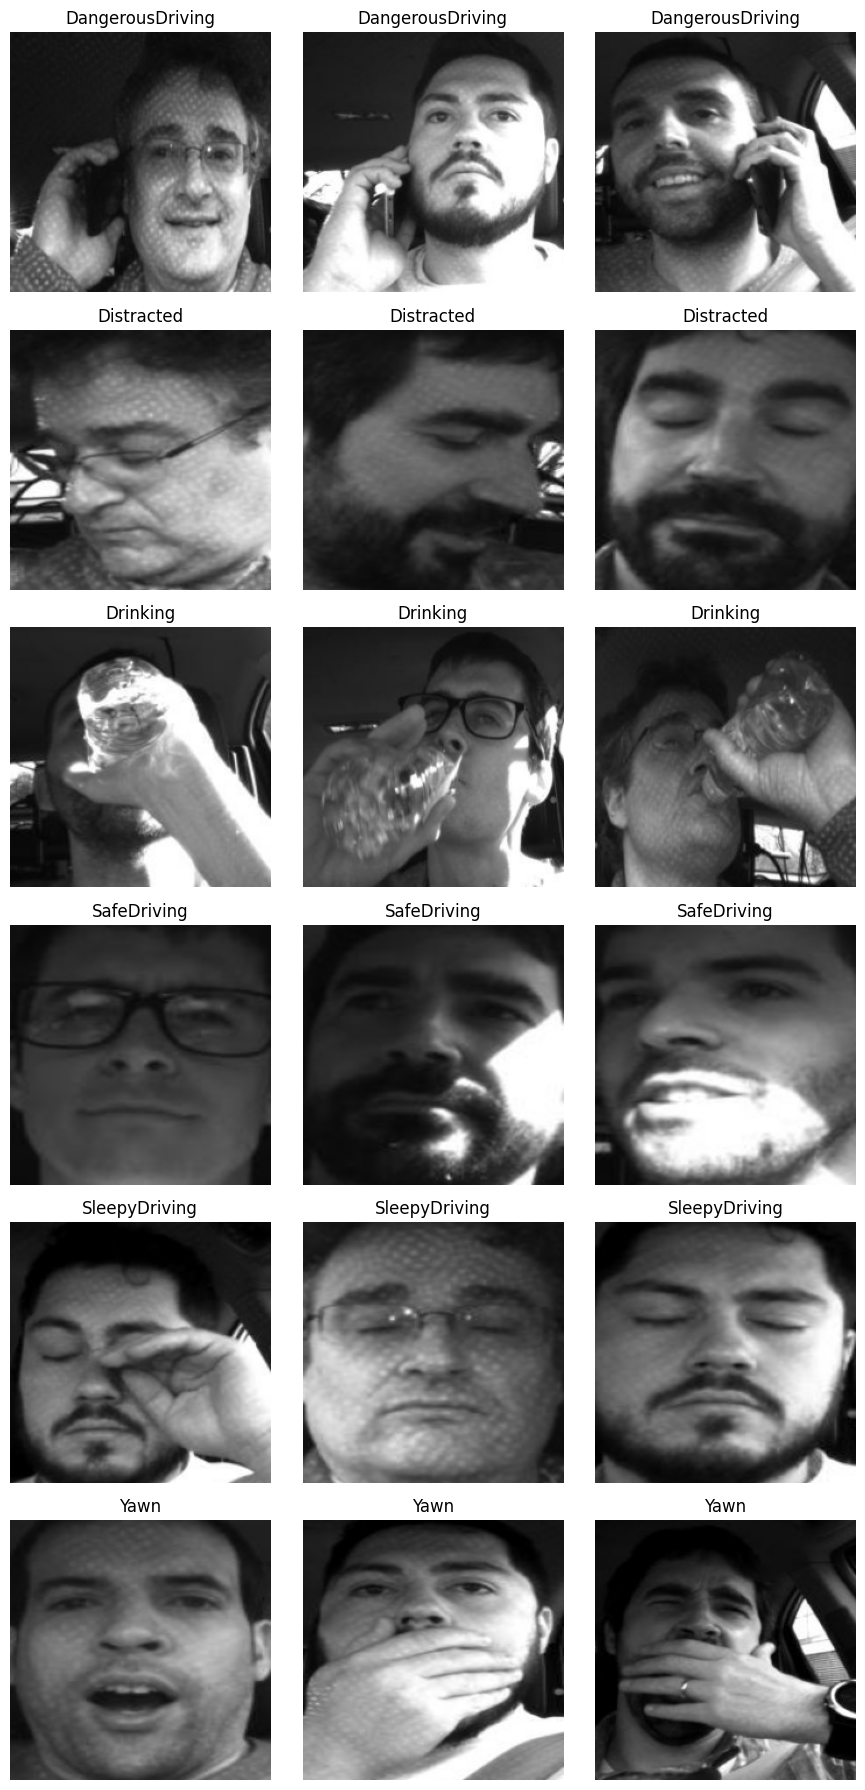


Validation Data Samples:


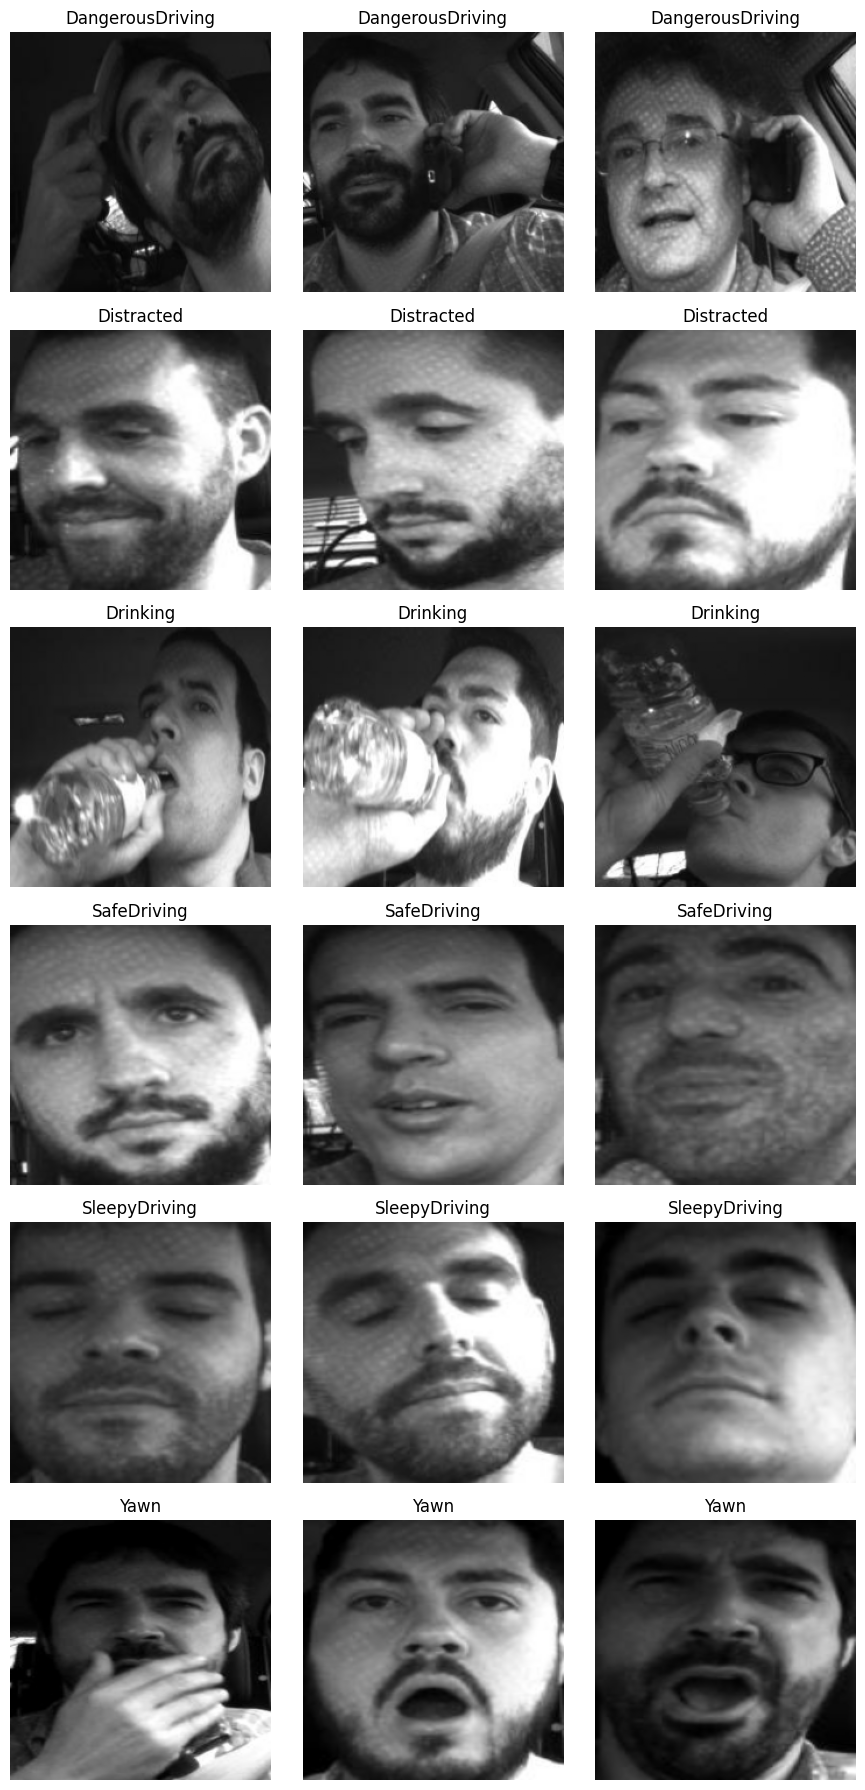


Testing Data Samples:


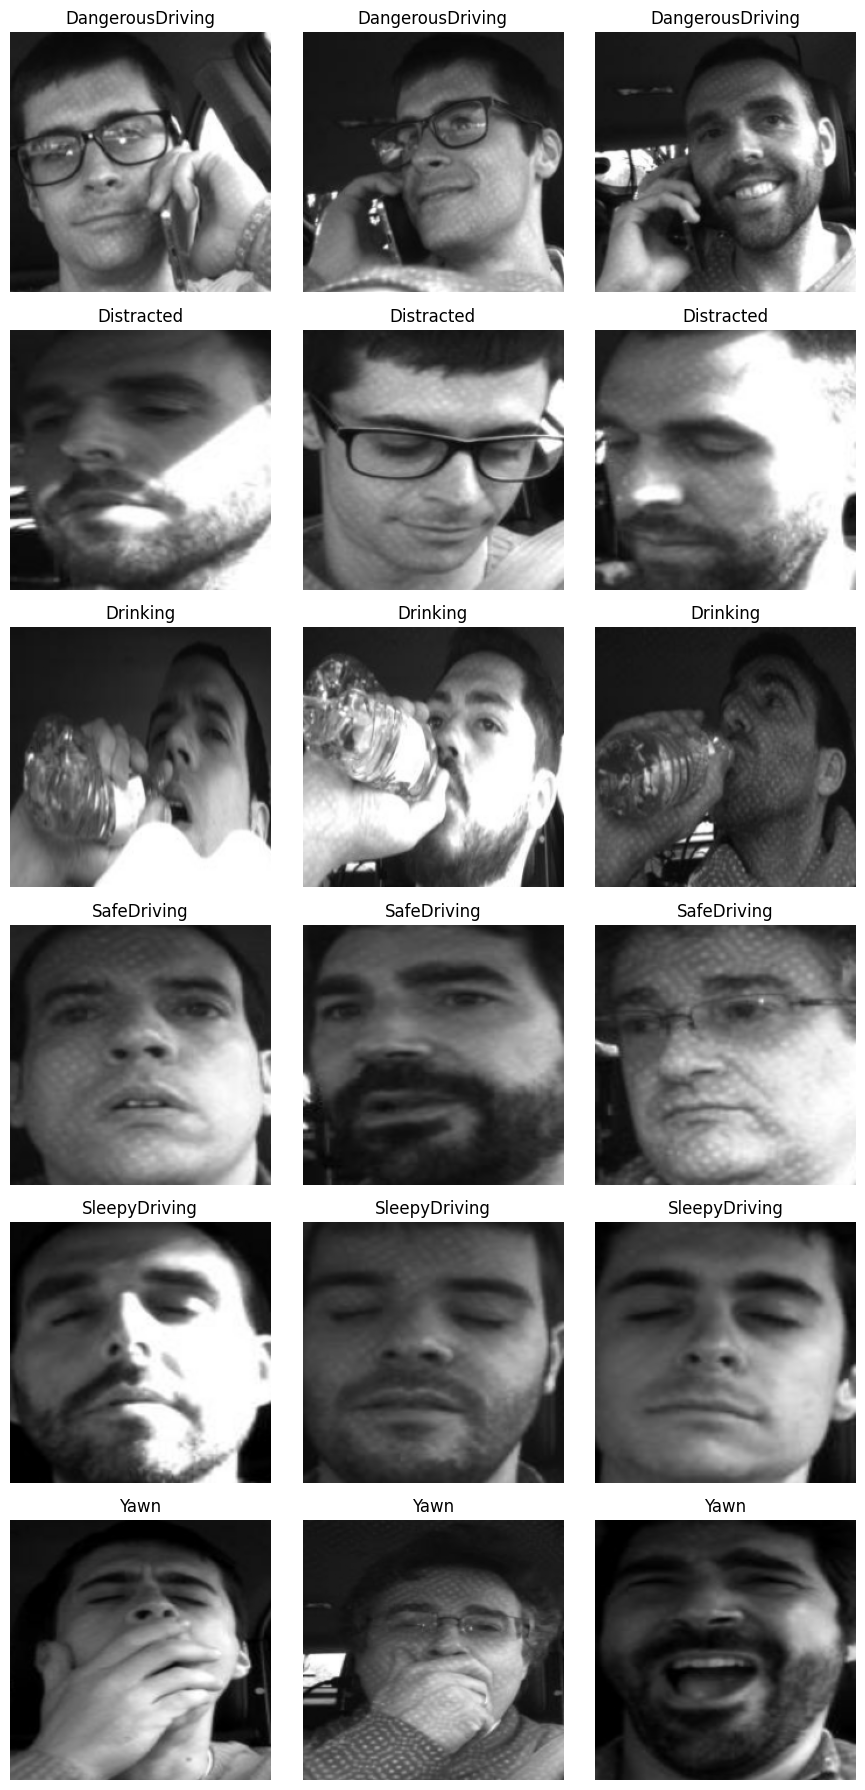


OOD Testing Data Samples:


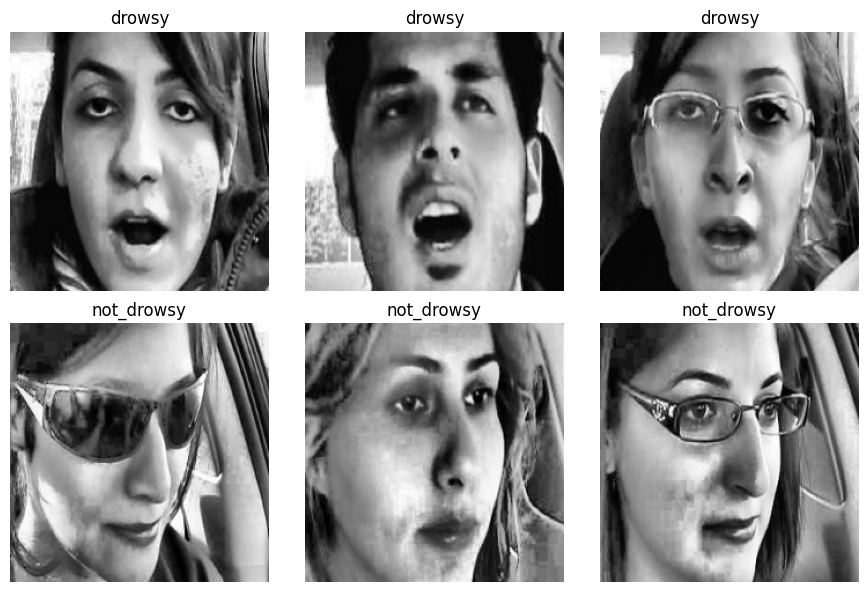

In [10]:
def visualize_samples(images, labels, class_names, n_samples=3):
    """Visualize sample images from each class"""
    class_indices = np.argmax(labels, axis=1)
    unique_classes = np.unique(class_indices)
    
    fig, axes = plt.subplots(len(unique_classes), n_samples, figsize=(n_samples*3, len(unique_classes)*3))
    
    if len(unique_classes) == 1:
        axes = np.array([axes])
    
    for i, cls in enumerate(unique_classes):
        # Get indices for this class
        cls_indices = np.where(class_indices == cls)[0]
        
        # Select random samples
        if len(cls_indices) >= n_samples:
            sample_indices = np.random.choice(cls_indices, n_samples, replace=False)
        else:
            sample_indices = cls_indices
            print(f"Warning: Class {cls} has only {len(cls_indices)} samples")
        
        # Display samples
        for j, idx in enumerate(sample_indices):
            if j < n_samples:  # Ensure we don't exceed the number of axes
                img = images[idx]
                
                ax = axes[i, j]
                ax.imshow(img)
                class_name = class_names[cls] if cls in class_names else f"Class {cls}"
                ax.set_title(f"{class_name}")
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples from each dataset
print("Training Data Samples:")
visualize_samples(X_train, y_train, class_names)

print("\nValidation Data Samples:")
visualize_samples(X_val, y_val, class_names)

print("\nTesting Data Samples:")
visualize_samples(X_test, y_test, class_names)

print("\nOOD Testing Data Samples:")
visualize_samples(X_ood_test, y_ood_test, ood_test_classnames)

# Model Training

In [11]:
def build_efficient_net_model(model_version = 'B0', pretrained=False):

    model_mapping = {
        'B0': tf.keras.applications.EfficientNetB0,
        'B1': tf.keras.applications.EfficientNetB1,
        'B4': tf.keras.applications.EfficientNetB4,
    }
    
    if model_version not in model_mapping:
        raise ValueError(f"Unsupported model version: {model_version}")

    weights = 'imagenet' if pretrained else None
    base_model = model_mapping[model_version](
        weights=weights, 
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    base_model.trainable = True
    
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.summary()

    # Count trainable parameters 
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    print(f"EfficientNet{model_version} - Trainable parameters: {trainable_params:,}")

    return model, trainable_params

In [12]:
class Trainer:
    def __init__(self, batch_size=16, class_names=class_names, model_version='B0', pretrained=False):
        self.model, self.trainable_params = build_efficient_net_model(model_version, pretrained)
        self.train_ds, self.val_ds, self.test_ds = self.create_datasets()
        self.class_weights = self.calc_class_weights()
        self.datagen = self.create_datagen()
        self.class_names = class_names
        
        # Callbacks
        self.callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                '/kaggle/working/best_model.weights.keras',
                save_best_only=True,
                monitor='val_loss'
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=7,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.2, 
                patience=3, 
                min_lr=1e-6
            )
        ]

    def create_datasets(self):
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
        
    def calc_class_weights(self):
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(np.argmax(self.train_ds[1], axis=1)),
            y=np.argmax(self.train_ds[1], axis=1)
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        # Boost underrepresented classes
        for key in class_weight_dict:
            if class_weight_dict[key] < 1.0:
                class_weight_dict[key] *= 1.5

        return class_weight_dict

    def create_datagen(self):
        # Data augmentation
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        return datagen

    def capture_and_save_results(self, model_version, history, training_start_time):
        """Captures and saves training results for model scaling analysis.
        
        Args:
            model_version: EfficientNet version (B0, B1, etc.)
            history: Training history object
            training_start_time: Time when training started (for calculating duration)
        """
        training_time = time.time() - training_start_time
        
        # Evaluate on test set
        test_results = self.model.evaluate(self.test_ds[0], self.test_ds[1], verbose=1)
        test_loss, test_accuracy = test_results
        
        # Create results dictionary
        results = {
            'model_version': model_version,
            'params': self.trainable_params,
            'training_history': {
                'accuracy': history.history['accuracy'],
                'loss': history.history['loss'],
                'val_accuracy': history.history['val_accuracy'],
                'val_loss': history.history['val_loss'],
                'learning_rate': history.history.get('lr', [])
            },
            'best_val_acc': max(history.history['val_accuracy']),
            'epoch_reached_best': np.argmax(history.history['val_accuracy']) + 1,
            'final_metrics': {
                'train_acc': history.history['accuracy'][-1],
                'val_acc': history.history['val_accuracy'][-1],
                'test_acc': test_accuracy,
                'test_loss': test_loss,
                'generalization_gap': history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
            },
            'training_time_seconds': training_time,
            'avg_epoch_time': training_time / len(history.history['accuracy']),
            'epochs_trained': len(history.history['accuracy'])
        }

        # Save to file
        filename = f'/kaggle/working/model_results_{model_version}.json'
        
        # Convert numpy values to Python native types for JSON serialization
        def convert_to_serializable(obj):
            if isinstance(obj, np.float32) or isinstance(obj, np.float64):
                return float(obj)
            elif isinstance(obj, np.int32) or isinstance(obj, np.int64):
                return int(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, list):
                return [convert_to_serializable(item) for item in obj]
            elif isinstance(obj, dict):
                return {k: convert_to_serializable(v) for k, v in obj.items()}
            else:
                return obj
                
        results = convert_to_serializable(results)
        
        with open(filename, 'w') as f:
            json.dump(results, f, indent=2)
        
        print(f"Results for EfficientNet{model_version} saved to {filename}")
        return results

    def train(self, epochs, model_version):
        # Record start time
        training_start_time = time.time()
    
        # Warmup GPU
        dummy_data = tf.random.uniform((1, 224, 224, 3))
        self.model.predict(dummy_data)
        
        self.model.compile(
            optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            metrics=['accuracy']
        )

        history = self.model.fit(
            self.datagen.flow(self.train_ds[0], self.train_ds[1], batch_size=16),
            validation_data=self.val_ds,
            epochs=epochs,
            class_weight=self.class_weights,
            callbacks=self.callbacks
        )
        
        # Capture and save results
        results = self.capture_and_save_results(model_version, history, training_start_time)
        
        return history, results

## Train

In [ ]:
# To train the three models, B0 (scratch), B4 (scratch), B4 (Pretrained), follow the steps below:

""" To train the model of interest, modify the following:

- model_version = B0 OR B1 OR B4
- for testing the pretrained B4, set "pretrained=True" 

For experimenting, Batch size and epochs are modifiables. 
"""

In [ ]:
# Create trainer and train model
model_version = 'B0'
pretrained = False

# uncomment to start training

# trainer = Trainer(batch_size=16, model_version=model_version, pretrained=pretrained)
# history, results = trainer.train(epochs=30, model_version=model_version)

# Evaluaiton

In [14]:
# assistant funcs

def evaluate_model(model, test_data, class_names):
    X_test, y_test = test_data
    
    batch_predictions = model.predict(X_test)
    
    predicted_classes = np.argmax(batch_predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    
    print("\nClassification Report:")
    class_names_list = list(class_names.values())
    print(classification_report(true_classes, predicted_classes, target_names=class_names_list))
    
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_list, 
                yticklabels=class_names_list)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print additional metrics
    print("\nDetailed Metrics:")
    print(f"Total samples: {len(true_classes)}")
    print(f"Accuracy: {(true_classes == predicted_classes).mean():.4f}")
    
    # Calculate per-class accuracy
    for i in range(len(class_names)):
        class_mask = true_classes == i
        if np.any(class_mask):  # Check if there are any samples in this class
            class_acc = (predicted_classes[class_mask] == i).mean()
            print(f"Class {i} ({class_names[i]}) accuracy: {class_acc:.4f}")
        else:
            print(f"Class {i} ({class_names[i]}): No samples")
    
    return batch_predictions, true_classes

UNSAFE_CLASS_INDICES = {0, 1, 2, 4, 5} 

def evaluate_model_ood(model, test_data, class_names_ood):
    X_test, y_test = test_data
    batch_predictions = model.predict(X_test)
    predicted_classes_6 = np.argmax(batch_predictions, axis=1)
    
    
    mapped_predicted_classes = np.array([0 if pred in UNSAFE_CLASS_INDICES else 1 for pred in predicted_classes_6])
    
    true_classes = np.argmax(y_test, axis=1)
    
    print("\nClassification Report (OOD Evaluation):")
    print(classification_report(true_classes, mapped_predicted_classes, target_names=class_names_ood))
    
    cm = confusion_matrix(true_classes, mapped_predicted_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_ood, 
                yticklabels=class_names_ood)
    plt.title('OOD Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\nDetailed Metrics:")
    print(f"Total OOD samples: {len(true_classes)}")
    print(f"Overall OOD Accuracy: {(true_classes == mapped_predicted_classes).mean():.4f}")

    return mapped_predicted_classes, true_classes


## B0 (Trained from scratch)

In [13]:
# load trained B0 model
model_version = 'B0'
pretrained = False
model_weights = '/kaggle/input/efficientnet_inattention_driver/tensorflow2/default/1/B0_16_batches.weights.keras'
model, trainable_params = build_efficient_net_model(model_version=model_version, pretrained=pretrained)
model.load_weights(model_weights)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,843,433 (18.48 MB)

 Trainable params: 4,798,850 (18.31 MB)

 Non-trainable params: 44,583 (174.16 KB)

EfficientNetB0 - Trainable parameters: 4,798,850


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,843,433 (18.48 MB)

 Trainable params: 4,798,850 (18.31 MB)

 Non-trainable params: 44,583 (174.16 KB)

### Evaluate In-Domain Dataset

I0000 00:00:1751142261.111194     233 service.cc:148] XLA service 0x784cf8002610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751142261.117667     233 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751142261.117688     233 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751142262.043839     233 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

I0000 00:00:1751142271.229740     233 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step

Classification Report:
                  precision    recall  f1-score   support

DangerousDriving       1.00      0.99      0.99       301
      Distracted       0.93      0.93      0.93       152
        Drinking       0.86      1.00      0.93        25
     SafeDriving       0.97      0.97      0.97       412
   SleepyDriving       0.93      0.91      0.92        69
            Yawn       0.96      1.00      0.98        26

        accuracy                           0.97       985
       macro avg       0.94      0.97      0.95       985
    weighted avg       0.97      0.97      0.97       985



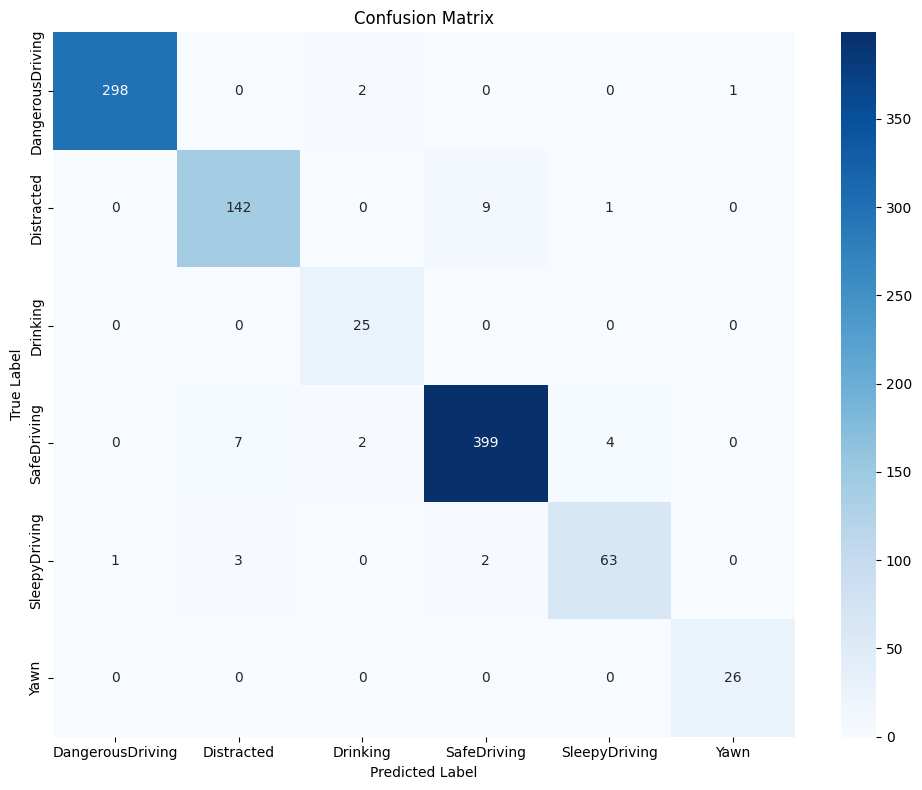


Detailed Metrics:
Total samples: 985
Accuracy: 0.9675
Class 0 (DangerousDriving) accuracy: 0.9900
Class 1 (Distracted) accuracy: 0.9342
Class 2 (Drinking) accuracy: 1.0000
Class 3 (SafeDriving) accuracy: 0.9684
Class 4 (SleepyDriving) accuracy: 0.9130
Class 5 (Yawn) accuracy: 1.0000


In [15]:
predictions, true_labels = evaluate_model(model, (X_test, y_test), class_names)

### Evaluate Out-Of-Domain Dataset

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 534ms/step

Classification Report (OOD Evaluation):
              precision    recall  f1-score   support

      drowsy       0.45      0.93      0.61       197
  not_drowsy       0.38      0.03      0.06       234

    accuracy                           0.45       431
   macro avg       0.41      0.48      0.33       431
weighted avg       0.41      0.45      0.31       431



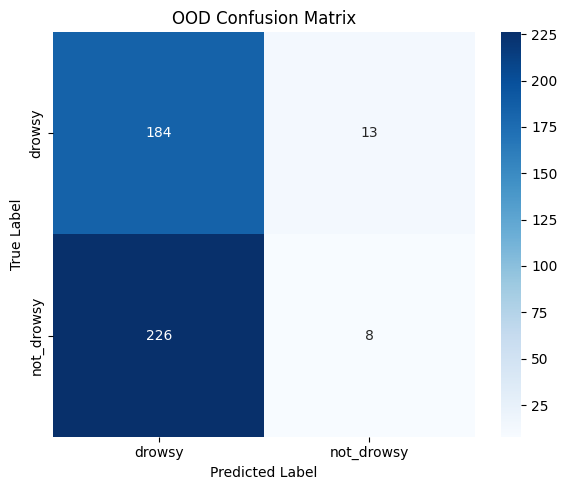


Detailed Metrics:
Total OOD samples: 431
Overall OOD Accuracy: 0.4455


In [16]:
OOD_CLASS_NAMES_LIST = ['drowsy', 'not_drowsy']

ood_predictions, ood_true_labels = evaluate_model_ood(
    model, 
    (X_ood_test, y_ood_test), 
    OOD_CLASS_NAMES_LIST
)

## B1 (Trained from scratch)

In [15]:
# load trained B1 model
model_version = 'B1'
pretrained = False
model_weights = '/kaggle/input/efficientnet_inattention_driver/tensorflow2/default/1/B1_16_batches.weights.keras'
model, trainable_params = build_efficient_net_model(model_version=model_version, pretrained=pretrained)
model.load_weights(model_weights)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,369,101 (28.11 MB)

 Trainable params: 7,304,486 (27.86 MB)

 Non-trainable params: 64,615 (252.41 KB)

EfficientNetB1 - Trainable parameters: 7,304,486


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,369,101 (28.11 MB)

 Trainable params: 7,304,486 (27.86 MB)

 Non-trainable params: 64,615 (252.41 KB)

### Evaluate In-Domain Dataset

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step

Classification Report:
                  precision    recall  f1-score   support

DangerousDriving       0.00      0.00      0.00       301
      Distracted       0.15      1.00      0.27       152
        Drinking       0.00      0.00      0.00        25
     SafeDriving       0.00      0.00      0.00       412
   SleepyDriving       0.00      0.00      0.00        69
            Yawn       0.00      0.00      0.00        26

        accuracy                           0.15       985
       macro avg       0.03      0.17      0.04       985
    weighted avg       0.02      0.15      0.04       985



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


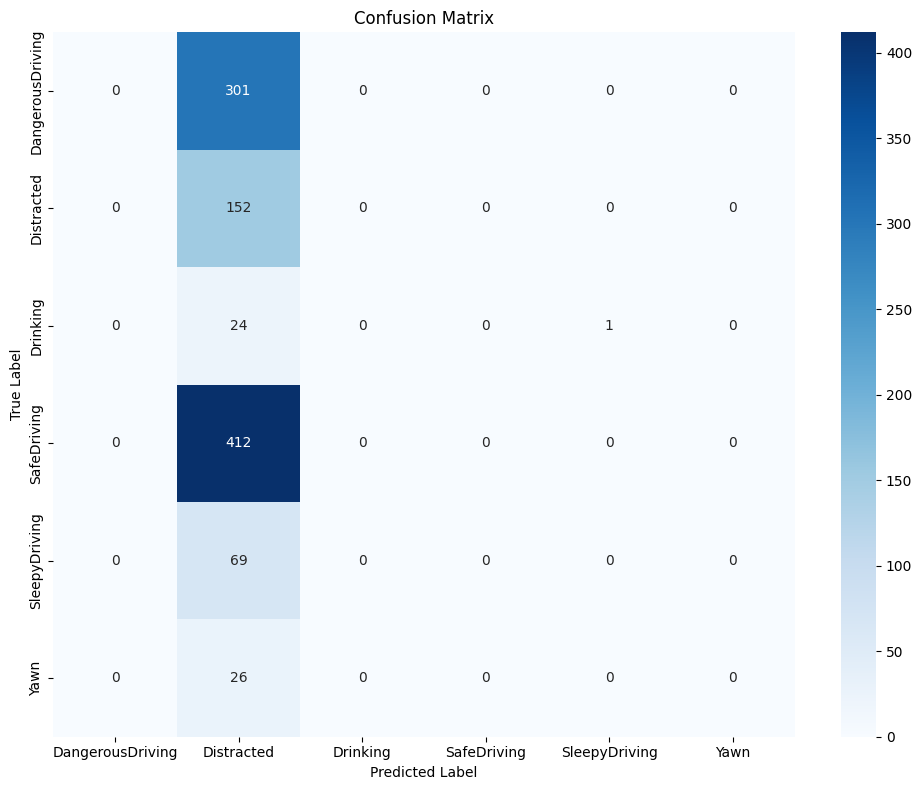


Detailed Metrics:
Total samples: 985
Accuracy: 0.1543
Class 0 (DangerousDriving) accuracy: 0.0000
Class 1 (Distracted) accuracy: 1.0000
Class 2 (Drinking) accuracy: 0.0000
Class 3 (SafeDriving) accuracy: 0.0000
Class 4 (SleepyDriving) accuracy: 0.0000
Class 5 (Yawn) accuracy: 0.0000


In [16]:
predictions, true_labels = evaluate_model(model, (X_test, y_test), class_names)

### Evaluate Out-Of-Domain Dataset

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 657ms/step

Classification Report (OOD Evaluation):
              precision    recall  f1-score   support

      drowsy       0.53      0.52      0.52       197
  not_drowsy       0.60      0.62      0.61       234

    accuracy                           0.57       431
   macro avg       0.57      0.57      0.57       431
weighted avg       0.57      0.57      0.57       431



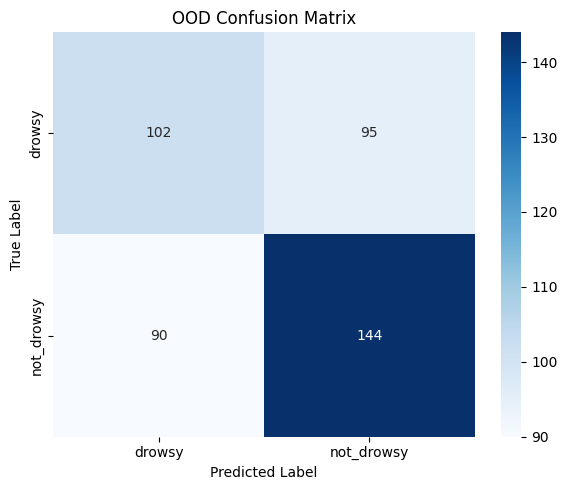


Detailed Metrics:
Total OOD samples: 431
Overall OOD Accuracy: 0.5708


In [17]:
OOD_CLASS_NAMES_LIST = ['drowsy', 'not_drowsy']

ood_predictions, ood_true_labels = evaluate_model_ood(
    model, 
    (X_ood_test, y_ood_test), 
    OOD_CLASS_NAMES_LIST
)

## B4 (pretrained ImageNet)

In [18]:
# load trained B4 model
model_version = 'B4'
pretrained = True
model_weights = '/kaggle/input/efficientnet_inattention_driver/tensorflow2/default/1/B4_Imagenet.weights.keras'
model, trainable_params = build_efficient_net_model(model_version=model_version, pretrained=pretrained)
model.load_weights(model_weights)
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 7, 7, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1792)                │           7,168 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,731,877 (71.46 MB)

 Trainable params: 18,603,086 (70.97 MB)

 Non-trainable params: 128,791 (503.09 KB)

EfficientNetB4 - Trainable parameters: 18,603,086


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 7, 7, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1792)                │           7,168 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,731,877 (71.46 MB)

 Trainable params: 18,603,086 (70.97 MB)

 Non-trainable params: 128,791 (503.09 KB)

### Evaluate In-Domain Dataset

31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 547ms/step

Classification Report:
                  precision    recall  f1-score   support

DangerousDriving       1.00      1.00      1.00       301
      Distracted       1.00      0.91      0.96       152
        Drinking       0.86      1.00      0.93        25
     SafeDriving       0.97      0.99      0.98       412
   SleepyDriving       0.96      0.99      0.97        69
            Yawn       0.96      1.00      0.98        26

        accuracy                           0.98       985
       macro avg       0.96      0.98      0.97       985
    weighted avg       0.98      0.98      0.98       985



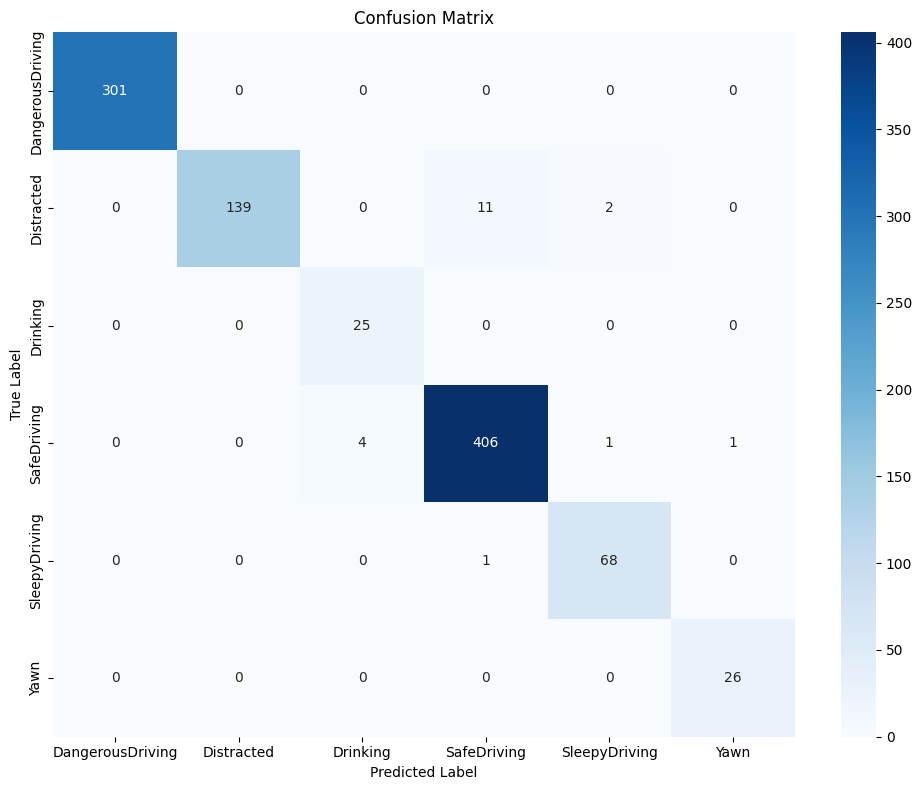


Detailed Metrics:
Total samples: 985
Accuracy: 0.9797
Class 0 (DangerousDriving) accuracy: 1.0000
Class 1 (Distracted) accuracy: 0.9145
Class 2 (Drinking) accuracy: 1.0000
Class 3 (SafeDriving) accuracy: 0.9854
Class 4 (SleepyDriving) accuracy: 0.9855
Class 5 (Yawn) accuracy: 1.0000


In [19]:
predictions, true_labels = evaluate_model(model, (X_test, y_test), class_names)

### Evaluate Out-Of-Domain Dataset

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 701ms/step

Classification Report (OOD Evaluation):
              precision    recall  f1-score   support

      drowsy       0.58      0.77      0.67       197
  not_drowsy       0.74      0.54      0.62       234

    accuracy                           0.65       431
   macro avg       0.66      0.66      0.64       431
weighted avg       0.67      0.65      0.64       431



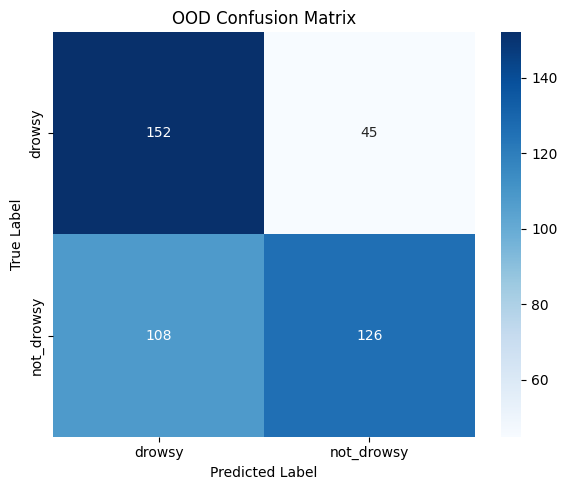


Detailed Metrics:
Total OOD samples: 431
Overall OOD Accuracy: 0.6450


In [20]:
OOD_CLASS_NAMES_LIST = ['drowsy', 'not_drowsy']

ood_predictions, ood_true_labels = evaluate_model_ood(
    model, 
    (X_ood_test, y_ood_test), 
    OOD_CLASS_NAMES_LIST
)